## ECON 2355 Implementation Exercise 4: Hyperparameter Tuning with Object Detection

This exercise has two main parts:
 - **1: Object Detection with YOLO**: This task gives and example of creating and training a object detection model with YOLO.
 - **2: Hyperparameter Tuning with Weights and Biases** This task sets up and runs Weights and Biases hyperparameter search on the model from the previous problem. We try to find the optimal hyperparameters for this model and dataset.

### **This Exercise Set provides most of the solutions**

Particularly in the first part, this set is less interactive than most of exercise sets to this point. Most of the solutions are provided. It's strongly encouraged to take the time to understand what the various provided snippets are doing and why they are there.

### Notes on the class's implementation exercises in general:

 - These exercises are still being finalized! If you encounter problems please don't hesitate to reach out: tom_bryan@fas.harvard.edu

 - You are welcome to download these notebooks and complete them on your local machine, or work on them in colab. If you are hoping to run things on your local machine you will likely want to set up an [Anaconda](https://www.anaconda.com/products/distribution) python environment and run notebooks from either [VS Code](https://code.visualstudio.com/download) or [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html). For your future Deep Learning-oriented endevours, knowing how to set up an environment to run the frameworks and libraries discussed here will likely be important, so it might not be a bad idea to try setting things up locally. On the other hand, working in colab is nice for reproducibility purposes--anyone can run and/or debug your code without problems.

 - Exercises in this class use [PyTorch](https://pytorch.org/get-started/locally/), the [dominant](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) research deep learning python framework. If you have a _compelling_ reason why you wish to become more familiar with another framework, like Tensorflow, reach out and we _may_ be able to accomodate that.

 - In these exercises we'll try to find the sweet spot between providing so much of the code that the implementation is meaningless and leaving so much that the work is overly tedious. Feedback is appreciated!

 - To submit the assignements, please save the exercise as a `.ipynb` file named `ECON_2355_Exercise_{n}_{firstname}_{lastname}.ipynb` and submit to the appropriate place in XXXXX  

 - These exercises are graded as complete/incomplete. _Complete_ is defined as showing effort to complete at least half of the steps.

 - Many of these exercises are adapted from other courses, tutorials, or other sources. Like any good social scientist, I list those sources, so should you choose there are often other places to look for help/partial solutions. How and when you use those resources are entirely up to you and your learning style. One caveat: outside sources for exercises will likely be less and less common as we progress through the course.  

### Exercise Set 4: Hyperparameter Tuning with Object Detection



### 1. Object Detection with YOLO

[YOLO](https://arxiv.org/pdf/1506.02640.pdf) is a popular object detection model first proposed in 2016. While we haven't yet covered Object Detection (the technique whereby models are trained to recognize objects in a scene) in class, many potential class projects involve object detection, so it features in this assignment.

On particularly popular implementation of YOLO is [yolov5], a modification on the original YOLO codebase that includes a port into PyTorch, which will help it play nicely with many of our familiar functions. In these exercises we will interact with the library both through its Python API and its Command Line Interface.

Let's start by installing the `yolov5` library.

In [ ]:
!pip install yolov5

#### **Important** After installing YOLOv5, restart your Colab runtime.
#### Do not run the `pip install yolov5` cell (above) again after restarting.  

This will reset some libraries and allow you to continue with the imports in a pain-free way. In particular, the PIL image manipulation library tends to be problematic without a runtime restart.

Now we import some addional necessary imports, many of which likely look familiar:

In [ ]:
import os
import torch
import torchvision
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from copy import deepcopy
import yaml

In [ ]:
!wget https://github.com/ultralytics/yolov5/blob/master/requirements.txt
!cp requirements.txt /usr/local/lib/python3.8/dist-packages/yolov5/
!cp /usr/local/lib/python3.8/dist-packages/yolov5/data/hyps/hyp.scratch-low.yaml /content/yolo_base_hyps.yaml

#### a) **Data and Examples**

Our task in this exercise is relatively simple: we imagine that we are working on an OCR engine which, as part of its process, detects all the lines in an image of text.

For example, given the following image:

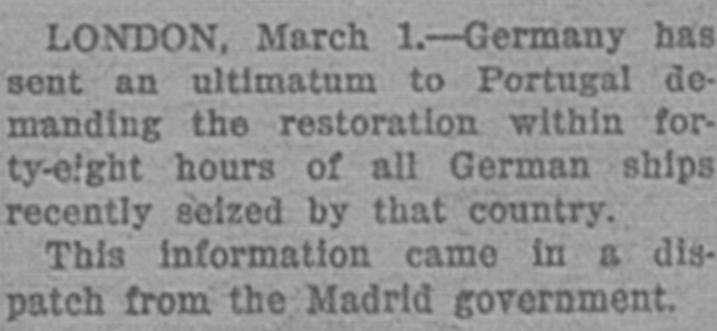

We want the model to output the following detections:

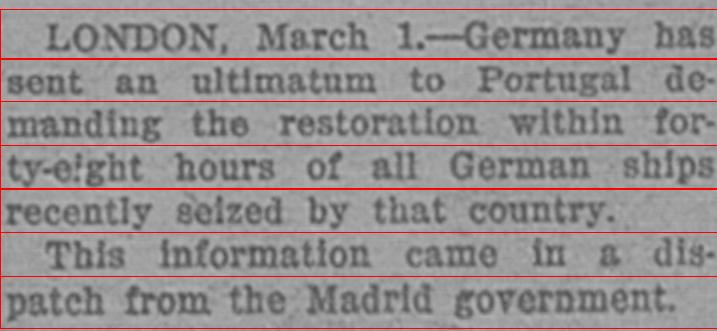

Where a box has been detected around each line in the text. _How exactly_ the model does this will be covered in future lectures. These exercises are more focused on the Hyperparameter Tuning portion, while using line detection as a useful use case.

To load the data, upload the `line_detection.zip` file attached to this Canvas assignment to the `/content/` folder in Google Colab (this is the default folder, so just pressing the upload button and selecting that zip folder should do the trick). Once you have done that, the following cell will unzip the folder:

In [ ]:
!unzip /content/line_detection.zip

What exactly does the data look like? In the `line_detection` folder you will see a file called `data.yaml` and three sub folders: `train`, `valid`, and `test`. The `data.yaml` file contains a simple description of the dataset: pointers towards the three other folders, the name of the objects being detected.

The three folders contain the actual images we will be training and testing on (in the `images` subfolders), each of which is associated with a matching label file (in the `labels` subfolders). The label files contain lists of objects present in the images (in this case lines of text).

#### b) **Training a Model with the YOLOv5 API**

The YOLOv5 API makes training a model extremely easy. To use pretrained (on ImageNet) weights, to train a model on the data described above we only have to call the following cell.

This cell takes about 15s per epoch, or ~2.5 minutes total, on a standard Colab GPU. Note the `--device 0` argument, which sets the model to run on `CUDA:0`, or the Colab GPU.

In [ ]:
!yolov5 train --weights /content/yolov5s.pt --data /content/line_detection/data.yaml --epochs 10 --device 0

What do the print outs mean? Inside of each epoch we should first see a training loop, which will display GPU memory used, loss from each of three sources:
- box_loss: How close the center of predicted boxes are to the actual centers
- obj_loss: How close in size the predicted boxes are to the actual ones
- cls_loss: Whether predicted boxes are the right class. (This should always be 0 in our examples, since we have only one class)

Underneath the training loop information is displayed about the validation accuracy. YOLO supplies four metrics:
- P: Precision
- R: Recall
- mAP50: Mean Average Precision (50)
- mAP50-95: Mean Average Precision (50-95)

[This resource](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/how-compute-accuracy-for-object-detection-works.htm) does a good job giving a high-level overview of each of these metrics. In short, having each one approach 1 indicates that the model is learning to accurately detect objects.

Once we have a trained model, we can call `detect` meaning that we evaluate the model on each image in a provided folder (in this case the entire validation set).   

In [ ]:
!yolov5 detect --source /content/line_detection/valid/images --weights /content/runs/train/exp/weights/best.pt --iou_thres 0.2 --conf_thres 0.4

This next cell displays one of the detected images. We should see fairly strong detections, with perhaps a few minor errors.

In [ ]:
from IPython.display import Image
Image('/content/runs/detect/exp/0101_s0_png.rf.603a1bfa6be1b9db4c7dbc9c07314f88.jpg')

#### c) **Lower Level Training of a YOLO Model**

When we trained the YOLO model a moment ago we used default hyperparameters--they were not tuned for our dataset or model (beyond the generic tuning the creators of YOLO did on ImageNet). However, our dataset bears relatively little resemblance to ImageNet, and we could expect to find a set of hyperparameters which preforms better than the defaults.

Our ultimate goal is to run a hyperparameter sweep on our model, training it with multiple sets of hyperparameters and empirically determining the optimal ones.

To do that, we need to be feeding in hyperparameters and getting out results at a slightly more granular level. The following cells help you recreate the YOLO training API called above within this notebook. This training loop is more complicated than ones we've worked with before, so quite a bit is done for you. Most of the cells don't require any work. Those that do have ⏰⏰⏰ symbols in the headers.

Adapted from https://github.com/ultralytics/yolov5/blob/master/train.py

##### i) Imports from the YOLO Module

In [ ]:
from yolov5.utils.loss import ComputeLoss
from yolov5.utils.dataloaders import create_dataloader
from yolov5.utils.torch_utils import smart_optimizer, de_parallel, ModelEMA, torch_distributed_zero_first
from yolov5.utils.general import TQDM_BAR_FORMAT, labels_to_class_weights, intersect_dicts, check_dataset, check_img_size, check_amp
from yolov5.utils.downloads import attempt_download
from yolov5.utils.callbacks import Callbacks
from yolov5.utils.autoanchor import check_anchors

from yolov5.models.yolo import Model
from yolov5.val import run as run_val
from yolov5 import load as load_yolov5

##### ii) Constants

This section defines a number of constants that will be used in setting up the training loop.

In [ ]:
weights = 'yolov5s.pt' # Pretrained Weights file
imgsz = 640 # YOLO takes in images in a fixed size, in this case 640x640

# Where to find default hyperparameters
hyp = '/content/yolo_base_hyps.yaml'
with open(hyp, errors='ignore') as f:
    hyp = yaml.safe_load(f)  # load hyps dict
hyp = hyp.copy()  # for saving hyps to checkpoints

resume = False # Not resuming from an earlier run
device = 'cuda' # Using the GPU
batch_size = 16 # Batch Size = 16 fits well on a Colab GPU

epochs = 10 # How many epochs to train for
amp = True # enabling Auto Mixed Precision (https://developer.nvidia.com/automatic-mixed-precision)

##### iii) Data Descriptors

This section defines metadata about the line detection dataset

In [ ]:
single_cls = False # Opting out of single class behavior (even though we only have one class)
data_dict = check_dataset('/content/line_detection/data.yaml') # Loading in metadata
train_path, val_path = data_dict['train'], data_dict['val'] # Pointing towards train and val datasets
nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
names = {0: 'item'} if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
is_coco = False # Not using some special settings used on the MS COCO Dataset

##### iv) Loading in the Model

This section loads in the model from downloaded pretrained weights. This section is a bit complicated, but essentially we are loading in the raw weights as a checkpoint, then creating a model designed to hold those weights, and then loading the weights from the checkpoint to the model.

You will likely see an `_ImcompatibleKeys` warning at the bottom of the output. This is OK and not a problem--the last layer is initialized automatically, not from the checkpoint.

In [ ]:
with torch_distributed_zero_first(-1):
    weights = attempt_download(weights)  # download if not found locally
ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak
model = Model(ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create empty model from checkpoint format
exclude = ['anchor'] if (hyp.get('anchors')) and not resume else []  # exclude keys
csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
model.load_state_dict(csd, strict=False)  # load weights from checkpoint state dict

##### v) Setting the model as trainable ⏰⏰⏰

In its initial state the model is not set to be trainable, since its parameters do not have the `requires_grad` attribute set to `True`. Iterate through the model's parameters and set `requires_grad` to `True` on each one.  

In [ ]:
# TODO: for each parameter in the model, set requires_grad to True
for k, v in model.named_parameters():
  v.requires_grad = True  # set all layers to trainable

##### vi) Optimizer, Exponential Moving Average

This next cell creates an Exponential Moving Average (EMA) tracker for the model, which will track a moving average of everything in the model's state dict (its parameters). EMA details can be found [here](https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage).

We also initialize an optimizer for the model, similarly to in former exercises.

In [ ]:
ema = ModelEMA(model) # Create EMA tracker

nbs = 64
accumulate = max(round(nbs / batch_size), 1)
hyp['weight_decay'] *= batch_size * accumulate / nbs # Scaling the weight decay parameter for optimizer
optimizer = smart_optimizer(model, 'SGD', hyp['lr0'], hyp['momentum'], hyp['weight_decay']) # Initialize optimizer

##### vii) Create Dataloaders

YOLO provides a convenient API for creating the dataloaders (and their associated datasets) from their associated folders.

In [ ]:
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader('/content/line_detection/train/', imgsz, batch_size, gs, single_cls = False, hyp = hyp, augment=True )
val_loader, dataset = create_dataloader('/content/line_detection/valid', imgsz, batch_size, gs, single_cls = False, hyp = hyp, rect=True, pad=0.5)
nb = len(train_loader) # Number of batches

##### viii) Anchors

One of the most important parameters to object detection is Anchor sizes. Anchors are default proposals which are then refined into bounding box predictions. If anchors are not appropriately sized for the dataset, the model cannot make accurate predictions. YOLO provides a helpful API for refining anchor box sizes:

In [ ]:
check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)  # run AutoAnchor

##### ix) Additional Hyperparameter Scaling

YOLO's hyperparameters are scaled to fit the model and context. These adjustments, taken from the YOLO train method, scale the parameters from their human-readable values in the hyperparameter dictionary to model-usable values to be passed in.

In [ ]:
nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
hyp['box'] *= 3 / nl  # scale to layers
hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
hyp['label_smoothing'] = False

model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.class_weights = labels_to_class_weights(dataset.labels, nc).to('cuda') * nc  # attach class weights
model.names = names # Attach class names

##### x) Last Steps

These last steps initialize the loss function and gradient scaler for the training process and create a few final constants.

In [ ]:
compute_loss = ComputeLoss(model) # Loss Function
scaler = torch.cuda.amp.GradScaler(enabled=True) # Gradient Scaler

callbacks = Callbacks() # Empty Callbacks object (since we don't have any that need to be run)
!mkdir /content/valid_results/
save_path = Path('/content/valid_results/') # Path to save validation metrics

##### xi) Train! ⏰⏰⏰

Finally we've arrived at the training loop. This should look quite similar to other training loops, with the only major difference being that gradients are accumulated over multiple steps before being used to update the model. This saves time, at a potential loss of accuracy (since the model is being updated less frequently).

Familar parts of the training loop have been left for you to fill in.

In [ ]:
last_opt_step = -1
for epoch in range(epochs):

  # TODO: Set model to training mode
  model.train()
  # TODO: Zero the optimizer gradients
  optimizer.zero_grad()
  pbar = tqdm(enumerate(train_loader), total=nb, bar_format=TQDM_BAR_FORMAT)  # create progress bar for this epoch

  for i, (imgs, targets, paths, _) in pbar: # Iterate through dataloader
    ni = i + nb * epoch # Compute batch number
    imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

    # Forward the model, compute loss
    with torch.cuda.amp.autocast(amp):
      # TODO: forward the model over the image batch
      pred = model(imgs)
      # TODO: compute the loss
      loss, loss_items = compute_loss(pred, targets.to(device))

    # Scale loss (since we've accumulated across multiple batches)
    loss = scaler.scale(loss)
    # TODO: Backpropagate the gradients
    loss.backward()

    # If we've accumulated enough gradients...
    if ni - last_opt_step >= accumulate:
      scaler.unscale_(optimizer)  # unscale gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
      scaler.step(optimizer)  # optimizer.step
      scaler.update()
      optimizer.zero_grad()
      if ema:
          ema.update(model) # Update EMA tracker
      last_opt_step = ni # Reset counter

  # Update EMA with hyperparameters, weights
  ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])

  # Call YOLO API Validation method
  results, maps, _, _ = run_val(data_dict,
                              batch_size=batch_size,
                              imgsz=imgsz,
                              half=True,
                              model=ema.ema,
                              single_cls=True,
                              dataloader=val_loader,
                              save_dir=save_path,
                              plots=False,
                              callbacks=callbacks,
                              compute_loss=compute_loss)

# Create a checkpoint for the trained model
ckpt = {
        'epoch': epochs,
        'model': deepcopy(de_parallel(model)).half(),
        'ema': deepcopy(ema.ema).half(),
        'updates': ema.updates,
        'optimizer': optimizer.state_dict()}

# Save last checkpoint
torch.save(ckpt, 'last.pt')

In most instances the above process should produce a model wiht precision, recall, and mAP50 all in the .7-.85 range and mAP50-95 in the .40-.55 range.

##### xii) Evaluate on Test Set

Now we can run the model on items from the Test set to check performance. Here we use the `yolov5.load` method to load in the saved `last.pt` checkpoint from before, then set a few detection parameters, run the model over an image from the test set, and then show the results using the YOLO API.

In [ ]:
model = load_yolov5('/content/last.pt')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic, this doesn't make much difference in our single-class situation
model.multi_label = False  # NMS multiple labels per box, this doesn't make much difference in our single-class situation
model.max_det = 1000  # maximum number of detections per image

img = '/content/line_detection/test/images/0394_s1_png.rf.663f9122a0dd50b0106b401a017648ca.jpg'

# perform inference
results = model(img)

# show detection bounding boxes on image
results.show()

### 2. Hyperparameter Sweep

In the above example we used default hyperparameters from the `yolo_base_hyps.yaml` file. You can open that file to view a list of hyperparameters and their default values.

Now we want to programatically search for better hyperparameter values. We will use [Weights and Biases](https://docs.wandb.ai/) to conduct that sweep and visualize results.

First, we need to install the associated library:

In [ ]:
!pip install wandb

In [ ]:
import wandb

#### a) **Making a Weights and Biases Account**

To use Weights and Biases (WandB) you will first need to create an account (if you don't already have one). To do this go to https://wandb.ai/site and click "Sign Up."

You will need to verify you email, then provide your name, institution, and a unique username.

After that you can login to Weights and Biases from this notebook by running the following cell:

In [ ]:
!wandb login --relogin

#### b) **Defining a Sweep Configuration**

Weights and Biases will automaticlaly run a hyperparameter sweep for us if we provide the necessary information. The first step is to create a dictionary in the fashion of the example [here](https://docs.wandb.ai/guides/sweeps/add-w-and-b-to-your-code#training-script-with-wb-python-sdk), which needs to include:
- The hyperparameter sweep `method` (grid search, random, or bayseian optimization)
- The `name` of the sweep
- The `metric` being used to evaluate the sweep
- A subdictionary named `parameters`, which provides a set of parameters and the values we wish to sweep over.

You will need to finish defining the sweep configuration, including selectin a method, giving the sweep a name, and selecting at least two more parameters to include in the sweep. You can include virtually any parameter provided in the `hyp` dictionary (you can see a list by opening `yolo_base_hyps.yaml`). You will need to remember to set all selected parameters to the values WandB provides inside the following problem.

In [ ]:
# TOOD: finish defining sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_mAP50'},
    'parameters':
    {
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.001},
        'imgsz': {'values': [640, 1280]}
     }
}

#### c) **Configuring Training and Validation for Hyperparameter Sweep**

The weights and biases sweep process expects as input a function name, which it will run on each iteration of the sweep. In this section we create a function called `main` which trains the model for a given set of hyperparameters. This is called a "run" of the sweep, which will create several runs and compare their performances.

`main` needs to implement the vast majority of the setup, training, and validation code above. In addition, WandB will supply a dictionary called `wandb.config` to `main`, which will be accessible in the function. `wandb.config` provides hyperparameters for a particular run of the hyperparameter sweep.

To track the process on Weights and Biases, you will need to call `wandb.log` after each validation step. This function allows you to provide a set of data about the run, which should include:
- The epoch number the run just evaluated on
- The validation percision
- The validation recall
- The validation mAP50

Helpfully, those attributes are easily accessed from the `results` returned from `run_val` (they are the first three values, respectively).

The comments here reference sections in Exercise 1 (c), which provide the marjority of the code needed in `main`. The difference is that instead of breaking them apart across many cells, here the whole process is packaged into a single function.

In [ ]:
# TODO: Finish implementing "main"
def main():

  # Initialize the Run
  run = wandb.init()

  # Code from part (ii)
  weights = 'yolov5s.pt' # Pretrained Weights file
  imgsz = 640 # YOLO takes in images in a fixed size, in this case 640x640

  # Where to find default hyperparameters
  hyp = '/content/yolo_base_hyps.yaml'
  with open(hyp, errors='ignore') as f:
      hyp = yaml.safe_load(f)  # load hyps dict
  hyp = hyp.copy()  # for saving hyps to checkpoints

  resume = False # Not resuming from an earlier run
  device = 'cuda' # Using the GPU
  batch_size = 16 # Batch Size = 16 fits well on a Colab GPU

  epochs = 10 # How many epochs to train for
  amp = True # enabling Auto Mixed Precision (https://developer.nvidia.com/automatic-mixed-precision)

  # Adjust hyperparameters with values from wandb.config
  imgsz = wandb.config.imgsz
  hyp['lr0'] = wandb.config.lr
  epochs = wandb.config.epochs

  # Code from part (iii)
  single_cls = False # Opting out of single class behavior (even though we only have one class)
  data_dict = check_dataset('/content/line_detection/data.yaml') # Loading in metadata
  train_path, val_path = data_dict['train'], data_dict['val'] # Pointing towards train and val datasets
  nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
  names = {0: 'item'} if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
  is_coco = False # Not using some special settings used on the MS COCO Dataset

  # Code from part (iv)
  with torch_distributed_zero_first(-1):
    weights = attempt_download(weights)  # download if not found locally
  ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak
  model = Model(ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
  exclude = ['anchor'] if (hyp.get('anchors')) and not resume else []  # exclude keys
  csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
  csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
  model.load_state_dict(csd, strict=False)  # load

  # Code from part (v)
  for k, v in model.named_parameters():
    v.requires_grad = True  # train all layers

  # Code from part (vi)
  ema = ModelEMA(model)

  nbs = 64
  accumulate = max(round(nbs / batch_size), 1)
  hyp['weight_decay'] *= batch_size * accumulate / nbs
  optimizer = smart_optimizer(model, 'SGD', hyp['lr0'], hyp['momentum'], hyp['weight_decay'])


  # Code from part (vii)
  gs = max(int(model.stride.max()), 32)  # grid size (max stride)
  imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

  train_loader, dataset = create_dataloader('/content/line_detection/train/', imgsz, batch_size, gs, single_cls = False, hyp = hyp, augment=True )
  val_loader, dataset = create_dataloader('/content/line_detection/valid', imgsz, batch_size, gs, single_cls = False, hyp = hyp, rect=True, pad=0.5)
  nb = len(train_loader)

  # Code from part (viii)
  check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)  # run AutoAnchor

  # Code from part (ix)
  nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
  hyp['box'] *= 3 / nl  # scale to layers
  hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
  hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
  hyp['label_smoothing'] = False

  model.nc = nc  # attach number of classes to model
  model.hyp = hyp  # attach hyperparameters to model
  model.class_weights = labels_to_class_weights(dataset.labels, nc).to('cuda') * nc  # attach class weights
  model.names = names # Attach class names

  # code from part (x)
  compute_loss = ComputeLoss(model)
  scaler = torch.cuda.amp.GradScaler(enabled=True)

  callbacks = Callbacks()
  save_path = Path('/content/valid_results/')

  # Code from part (xi)
  last_opt_step = -1
  for epoch in range(epochs):

    model.train()
    optimizer.zero_grad()
    pbar = tqdm(enumerate(train_loader), total=nb, bar_format=TQDM_BAR_FORMAT)  # progress bar

    for i, (imgs, targets, paths, _) in pbar:
      ni = i + nb * epoch
      imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

      with torch.cuda.amp.autocast(amp):
        pred = model(imgs)  # forward
        loss, loss_items = compute_loss(pred, targets.to(device))

      scaler.scale(loss).backward()

      if ni - last_opt_step >= accumulate:
        scaler.unscale_(optimizer)  # unscale gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
        scaler.step(optimizer)  # optimizer.step
        scaler.update()
        optimizer.zero_grad()
        if ema:
            ema.update(model)
        last_opt_step = ni

    ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
    results, maps, _, _ = run_val(data_dict,
                                batch_size=batch_size,
                                imgsz=imgsz,
                                half=True,
                                model=ema.ema,
                                single_cls=True,
                                dataloader=val_loader,
                                save_dir=save_path,
                                plots=False,
                                callbacks=callbacks,
                                compute_loss=compute_loss)

    # Log results to Weights and Biases with wandb.log
    wandb.log({
            'epoch': epoch,
            'precision': results[0],
            'recall': results[1],
            'val_mAP50': results[2],
            'val_mAP50:95': results[3]
    })

#### d) **Run Hyperparameter Sweep**

Running the hyperparameter sweep has two parts:
- Register the sweep by calling `wandb.sweep`
- Call the sweep with `wandb.agent`

Those operations are provided for you, you will only need to set a project name (can be anything) and a number of runs (it's suggested to start with 3-5 to make sure things are working correctly, then expand to more as time permits).

In [ ]:
# TODO: Fill in a project name
sweep_id = wandb.sweep(sweep=sweep_configuration, project='yolo_test_sweep_2')

# TODO: Fill in the number of runs to complete
wandb.agent(sweep_id, function=main, count=5)

#### e) **Visualize Sweep Results**

You can view your hyperparameter sweep results at https://wandb.ai/{username}/{project_name}/sweeps/. There are a number of ways to view the output, including:
- Graphical Data, plotting each run against each other
- Tabular data (click the `Table` icon on the left side of the screen)

Another popular visualization technique is a [Parallel Cooridnates plot](https://docs.wandb.ai/guides/app/features/panels/parallel-coordinates), which summarizes the relationship between a large number of hyperparameters. You can create one once the sweep is done by pressing `Add panel` in the top right of the WandB dashboard, then `Parallel Coordinates`, and then selecting the relevant columns. Typically `mAP50` would be the rightmost one.

**Finish this exercise by pasting in a copy of a sample parallel coordinates plot from your hyperparameter sweep.**